In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import cont2discrete
from scipy.optimize import curve_fit
from scipy.ndimage import  zoom
import warnings

In [2]:


def apparentBarrier(d, G, phi):
    return 0.5*G* np.exp(-1.025 *phi* d)

def stm_sim(u, h, x, dt, params): # estado da ponta de prova, sinal de entrada, altura da amostra, passo, parâmetros de configuração
    
    dx_dt = np.zeros(3)

    dx_dt[0] = x[1]
    dx_dt[1] =  (1/params['m'])*(params['d']*u -params['b_']*x[1] -params['a']*params['ki']*x[0] - (1-params['a'])*params['ki']*x[2])
    dx_dt[2] = x[1]*(params['alpha'] -(params['beta']*np.sign(x[2]*x[1])+params['gamma'])*np.abs(x[2])**params['n'])

    new_x = x + dt*dx_dt # Método de Euler 
    
    delta_z = params['offset'] - new_x[0] - h # distância da ponta de prova até a superfície

    current = params['sigma']*params['Vb']*np.exp(-1.025*np.sqrt(params['work_fn'])*delta_z)

    linearized_current = np.log(current)

    return linearized_current, delta_z, new_x


def stm_sim_image(u,image, a,b, x, dt, params): # estado da ponta de prova, sinal de entrada, altura da amostra, passo, parâmetros de configuração
    
    dx_dt = np.zeros(3)

    dx_dt[0] = x[1]
    dx_dt[1] =  (1/params['m'])*(params['d']*u -params['b_']*x[1] -params['a']*params['ki']*x[0] - (1-params['a'])*params['ki']*x[2])
    dx_dt[2] = 0 # x[1]*(params['alpha'] -(params['beta']*np.sign(x[2]*x[1])+params['gamma'])*np.abs(x[2])**params['n'])

    new_x = x + dt*dx_dt # Método de Euler 
    
    delta_z = params['offset'] - new_x[0] # distância da ponta de prova até a superfície

    max_point = 40 #np.argmax(image[a,b]) + 10
    height_factor = 0.06160614
    xs = np.arange(max_point,image.shape[-1], 1)*height_factor
    ys = image[a,b,max_point:]
    p0 = (1., 1.) # start with values near those we expect
    paramsB, cv = curve_fit(apparentBarrier, xs, ys, p0)

    G, phi = paramsB
    linearized_current = np.log(apparentBarrier(delta_z, G, phi))
    return linearized_current, delta_z, new_x

plant_params = {
                'sigma': 20, # Coeficiente de proporcionalidade da corrente de tunelamento
                'work_fn':4.7, # Função trabalho
                'Vb':.5, # Tensão de polarização
                'offset': 5., # distancia do piezo com relação a menor altura
                'm': .1, # Massa do piezo
                'b_': 5, # Coeficiente de viscosidade
                'a': .95, # Coeficiente de pós-escoamento
                'ki': 90, # rigidez
                'd': 90, # Coeficiente do piezo m/V

                # Constantes para medir o deslocamento inerente à histerese
                'alpha': 1, 
                'beta': 0.8,
                'gamma': 0.2,
                'n': 2,}

def generate_random_inputs(t):
    
    data = np.zeros_like(t)
    frequencies = np.array([1, 10, 50, 100, 150, 200, 250, 300, 400, 450, 500])
    phases = np.array([np.random.uniform(-np.pi/2, np.pi/2) for i in range(frequencies.shape[0])])
    amplitudes = np.array([1/frequencies[i] for i in range(frequencies.shape[0])])
    
    for k, _ in enumerate(frequencies):
        data += amplitudes[k]*np.sin(2*np.pi*frequencies[k]*t + phases[k])
    return data

In [11]:
final = 100
dt = 1e-3
sample_rate = dt
t = np.arange(0, final, sample_rate)
atom_radius = 3
n_atoms = 20
correction_constant = (atom_radius*n_atoms)/final
w = np.pi*n_atoms/final
h = np.sin(w*t)**2

mi = 1e-3
mi2 = 50
mi3 = 1e-4
Ac = -1



K = 1
tau = .2
reference_model = cont2discrete(([K],[tau,1]), dt=sample_rate, method='euler')
am = reference_model[0].squeeze()
bm = -reference_model[1].squeeze() # inverter por conta da forma do filtro IIR: 1 - b0 - b1 - ... - bn

xd = np.zeros_like(t) + np.log(1)# + 0.005*np.random.uniform(-1, 1, len(t))
y_stm_past = 0
xm = np.zeros_like(am)
ym = np.zeros_like(bm)

y_ref = np.zeros_like(t)

u_control = np.zeros_like(t)


y_pred_control = np.zeros_like(t)
y_stm = np.zeros_like(t)
z_stm = np.zeros_like(t)
e = np.zeros(3)
e_list = np.zeros_like(t)
states = np.zeros(3)
delta_z_list = np.zeros_like(t)

up = ui = ud = 0
Kp = Ki = Kd = 0

Kp_list = np.zeros_like(t)
Ki_list = np.zeros_like(t) 
Kd_list = np.zeros_like(t)



In [12]:
for i, k in enumerate(t):
    Kp_list[i] = Kp
    Ki_list[i] = Ki
    Kd_list[i] = Kd

    xm = np.roll(xm,1)
    xm[0] = xd[i]
    ym = np.roll(ym,1)

    if i ==0:
        y_stm[i], delta_z_list[i], states = stm_sim(0, h[i] , states, dt,plant_params)
        states = np.zeros(3)
        ym[0] = y_stm[i]
        
        
    else:
        y_stm[i], delta_z_list[i], states = stm_sim(u_control[i-1], h[i], states, dt,plant_params)
        z_stm[i] = states[0]

        ym[0] = np.dot(am, xm) + np.dot(bm[1:], ym[1:])


    

    
    y_ref[i] = ym[0] # Saída  do modelo de referência
    e_list[i] = y_ref[i] - y_stm[i] 
    e = np.roll(e,1)
    e[0] = e_list[i]
    
    up = Kp*e[1]

    ui = ui + Ki*dt*e[1]

    ud = (Kd/dt)*(e[1] - e[2])

    u_control[i] = up + ui + ud

    Kp = Kp + 2*mi*e[0]*(-1/Ac)*e[1]
    Ki = Ki + 2*mi2*e[0]*(-1/Ac)*dt*e[1] + 2*mi2*e[1]*(-1/Ac)*dt*e[2]
    Kd = Kd + 2*mi3*e[0]*(-1/Ac)*(1/dt)*(e[1] - e[2])
    print(Kp, Ki, Kd)
    



    

    

0.0 0.0 0.0
0.0 0.0 0.0
7.738491784104517e-06 0.0003869245892052259 0.0007738491784104518
3.08371560167063e-05 0.0019287823900405409 0.0019258646407599917
7.680222097124456e-05 0.005381968849397543 0.0034502980498230607
0.00015300209390590837 0.011490215743857647 0.005340879726990772
0.0002665973244589088 0.02097997091824086 0.0075870453058348745
0.0004244546835416649 0.03455260040002868 0.010173791999670691
0.0006330428551729165 0.05287487693572906 0.013080763713025538
0.000898314969104831 0.07656789121388735 0.016281595954413523
0.0012255846442668077 0.10619498066858192 0.019743591514124526
0.001619403663840968 0.1422494154053888 0.023427798635419054
0.0020834505923955 0.1851427128118234 0.027289551879465412
0.00262044024962214 0.235194542100882 0.03127950777297373
0.0032320636711847036 0.2926251960403422 0.03534516440208209
0.003918966786630771 0.35755152289077374 0.03943279978330418
0.004680773446620731 0.42998701166257514 0.04348970503068432
0.005516154766715961 0.5098464106668347

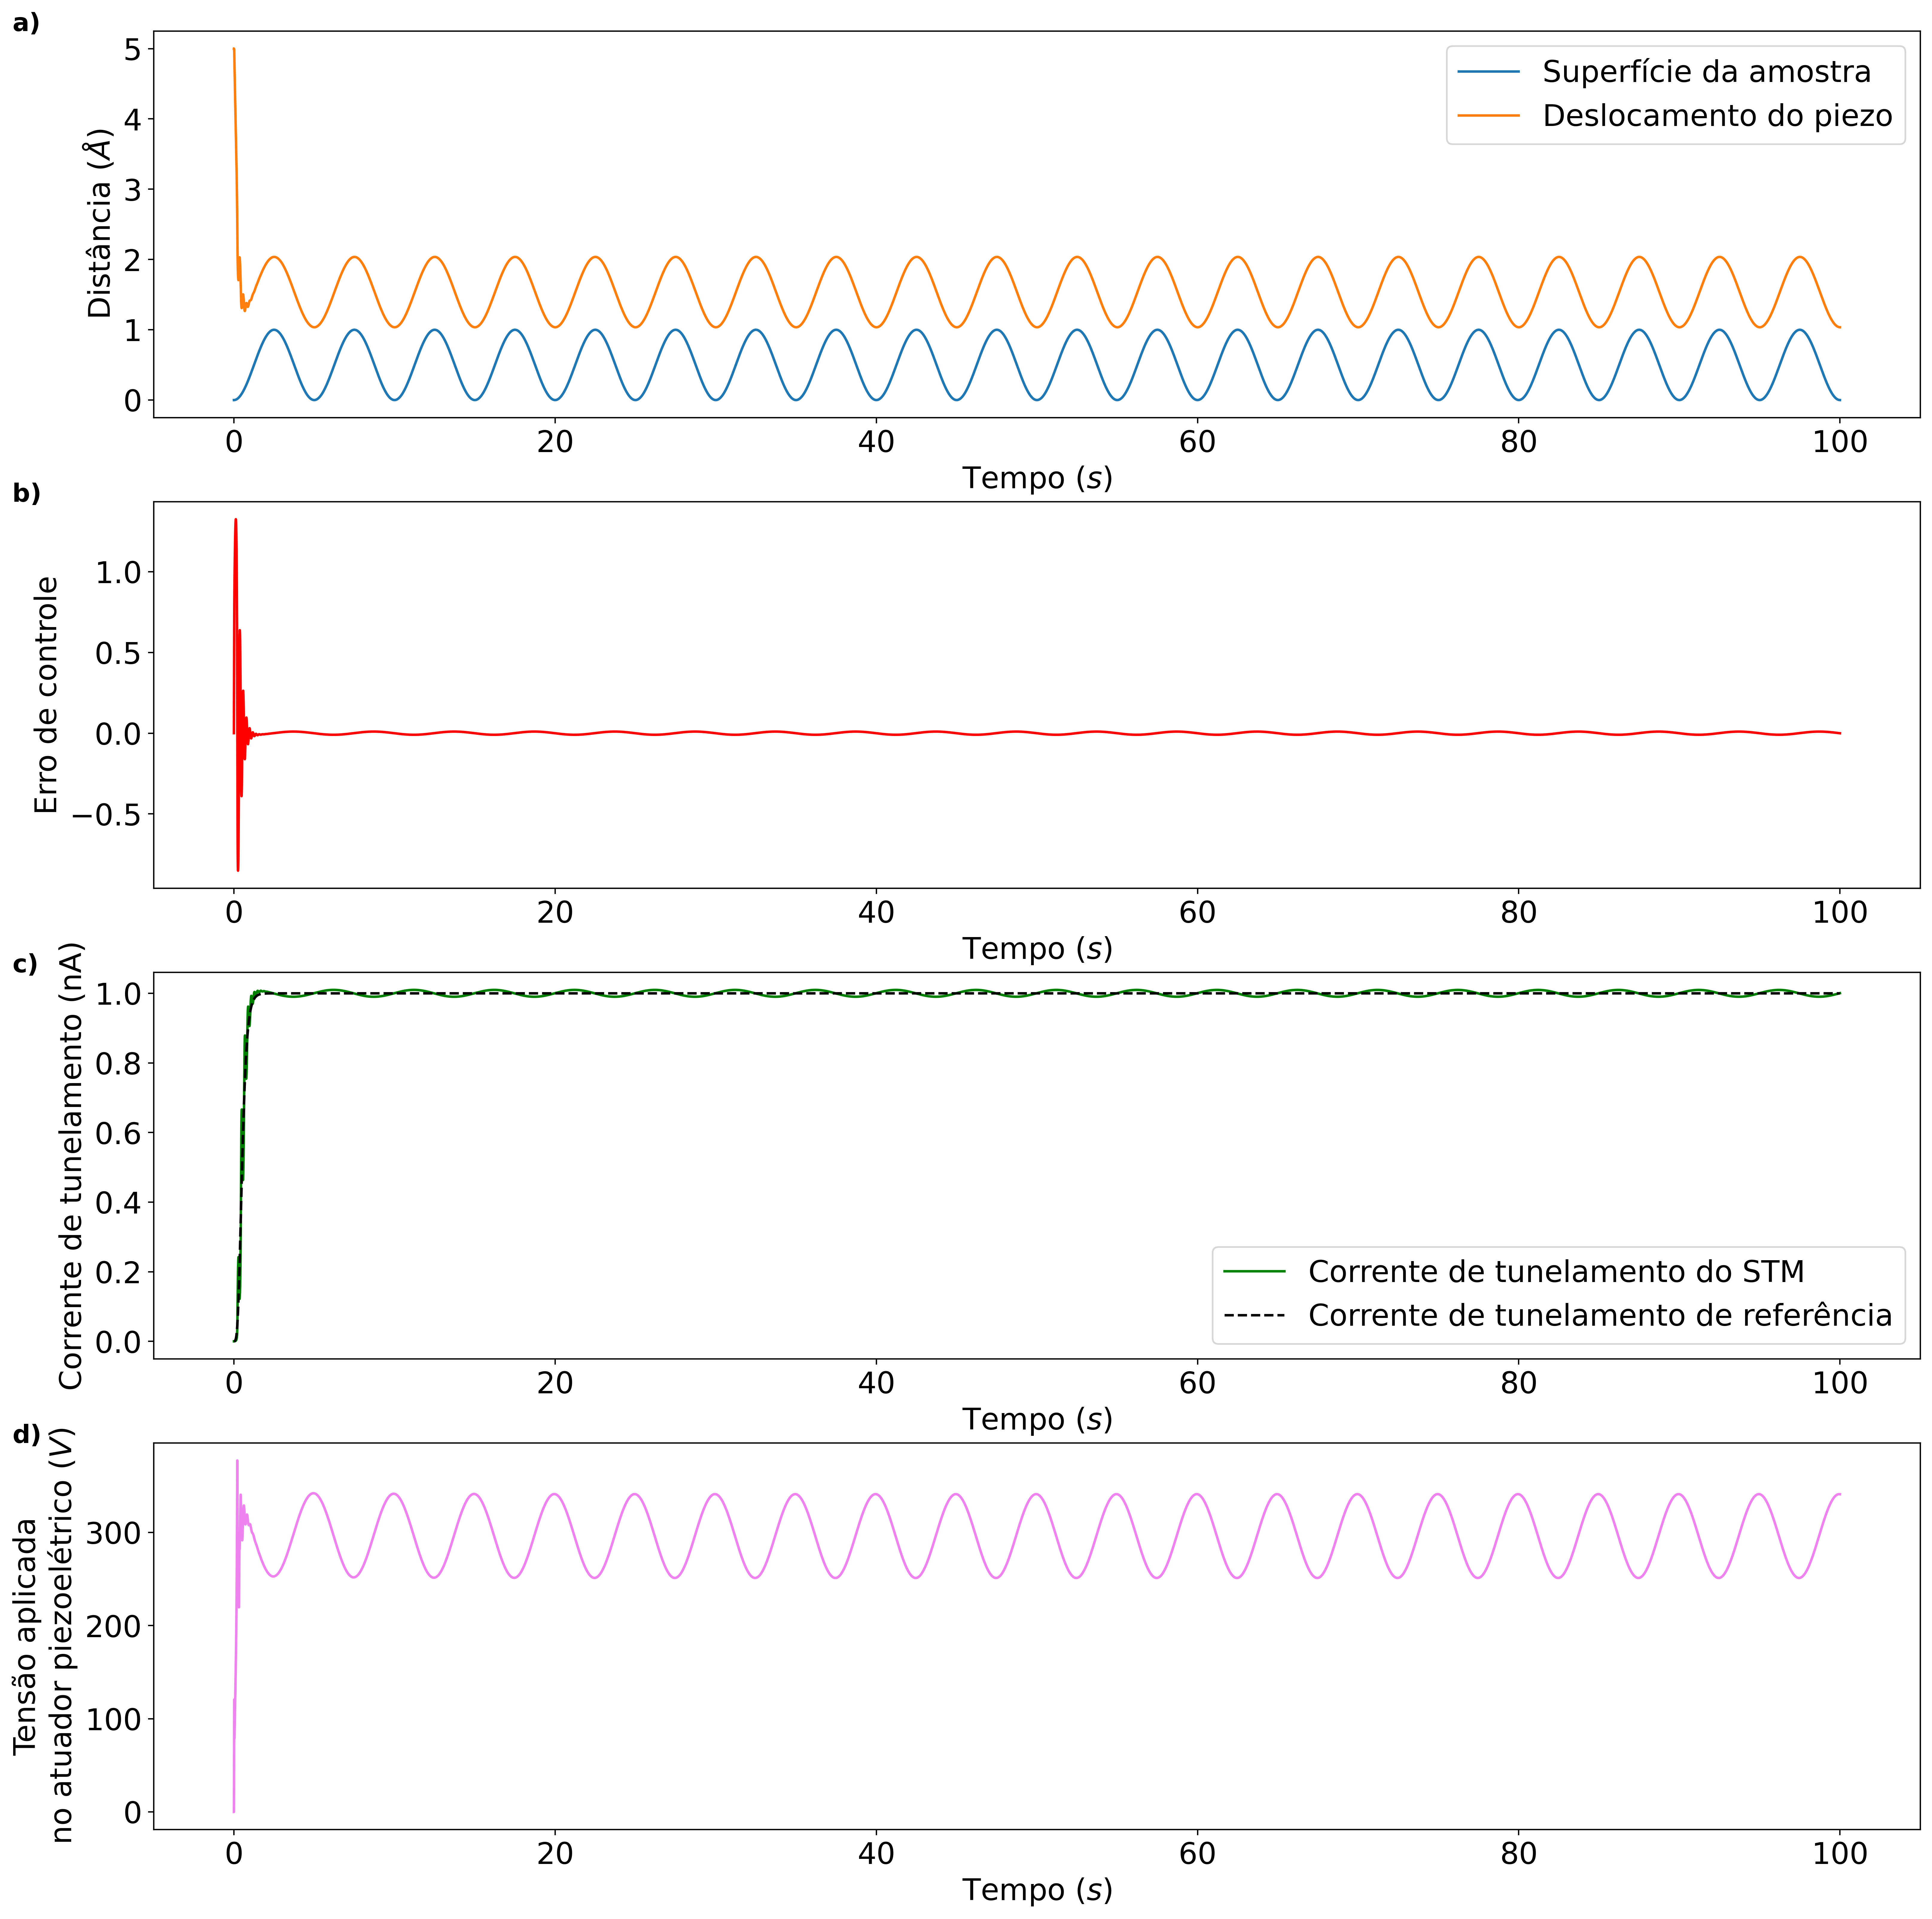

In [17]:
import matplotlib.pyplot as plt
import string

import matplotlib
matplotlib.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(4,1,)

fig.set_size_inches(16, 16)
fig.tight_layout()
fig.dpi = 400

axs[0].set_ylabel("Distância ($\AA$)")
axs[0].set_xlabel("Tempo ($s$)")
axs[0].plot(t, h, t, h+ delta_z_list)
axs[0].legend(["Superfície da amostra", "Deslocamento do piezo"])

axs[1].set_ylabel("Erro de controle")
axs[1].set_xlabel("Tempo ($s$)")
axs[1].plot(t, e_list, 'r')

axs[2].set_ylabel("Corrente de tunelamento (nA)")
axs[2].set_xlabel("Tempo ($s$)")
axs[2].plot(t, np.exp(y_stm), 'g', t, np.exp(y_ref),'k--')
axs[2].legend(["Corrente de tunelamento do STM", "Corrente de tunelamento de referência"])

axs[3].set_ylabel("Tensão aplicada\nno atuador piezoelétrico ($V$)")
axs[3].set_xlabel("Tempo ($s$)")
axs[3].plot(t, plant_params['d']*u_control, 'violet')

for n, ax in enumerate(axs):
    ax.text(-0.08, 1, f'{string.ascii_lowercase[n]})', transform=ax.transAxes, size=15, weight='bold')
plt.show()



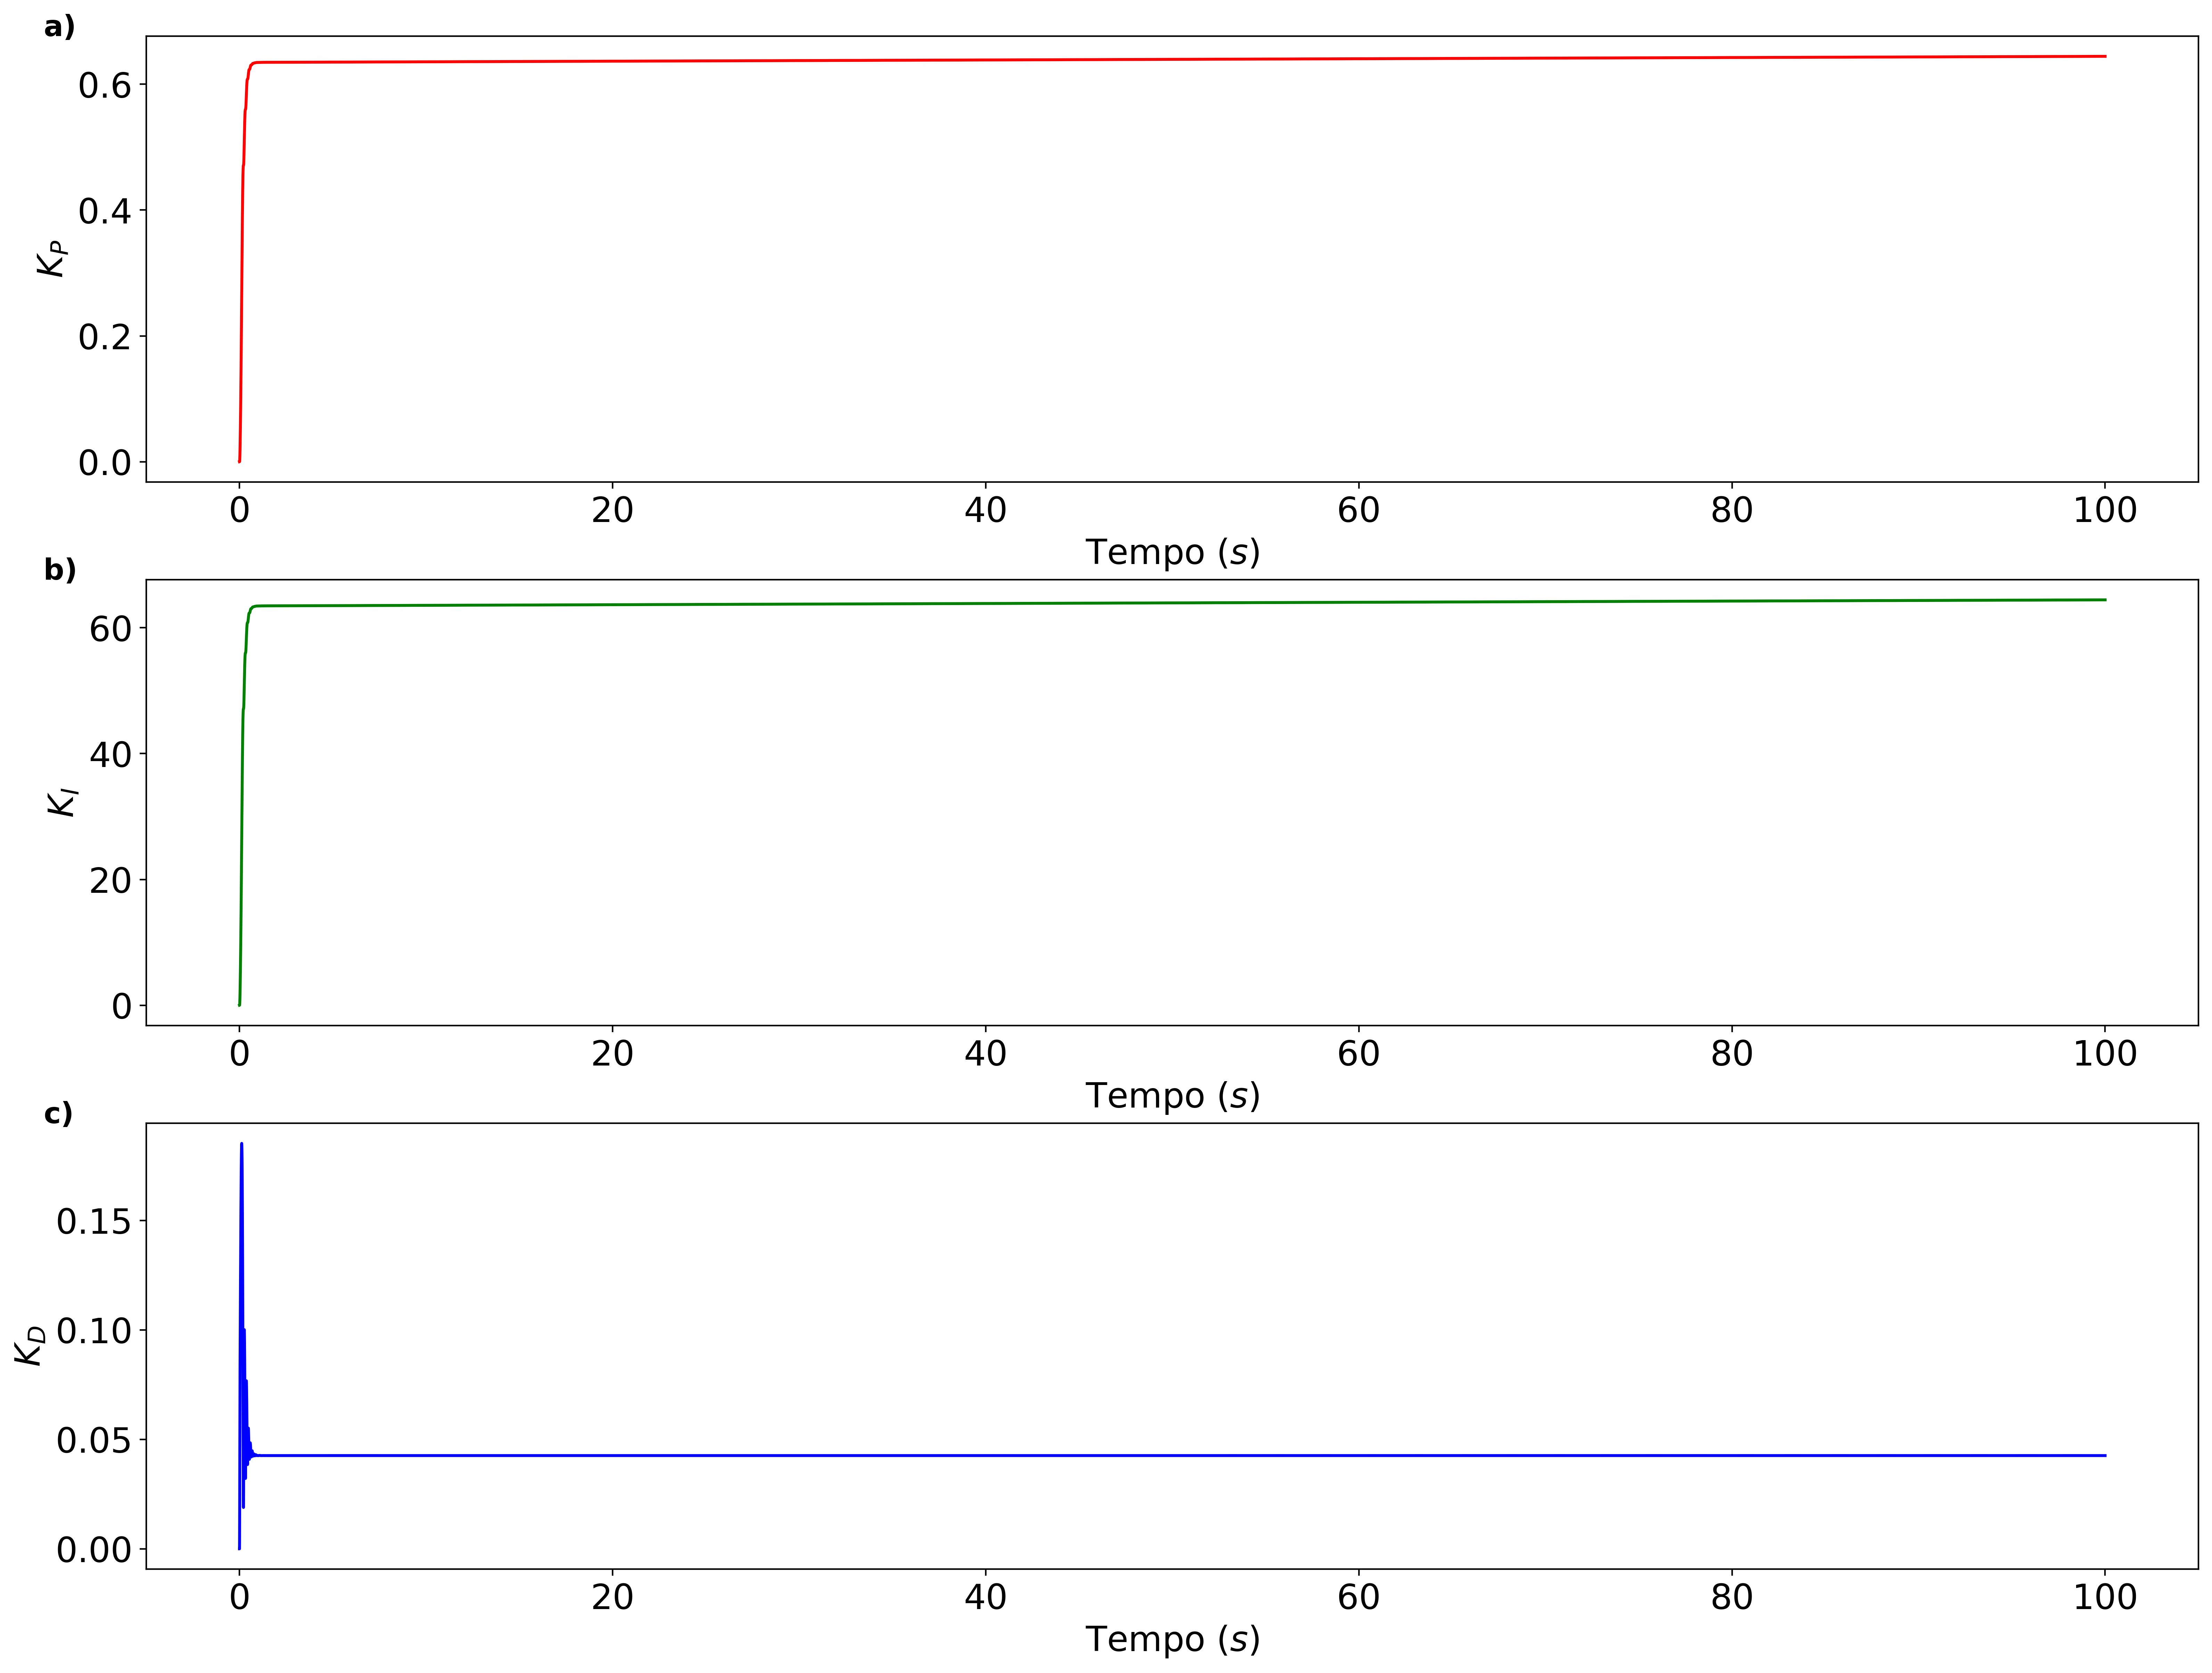

In [18]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(3,1)
fig.set_size_inches(16,12)
fig.tight_layout()
fig.dpi = 400


axs[0].set_ylabel("$K_P$")
axs[0].set_xlabel("Tempo ($s$)")
axs[0].plot(t, Kp_list, 'r')

axs[1].set_ylabel("$K_I$")
axs[1].set_xlabel("Tempo ($s$)")
axs[1].plot(t, Ki_list, 'g')

axs[2].set_ylabel("$K_D$")
axs[2].set_xlabel("Tempo ($s$)")
axs[2].plot(t, Kd_list, 'b')



for n, ax in enumerate(axs):
    ax.text(-0.05, 1, f'{string.ascii_lowercase[n]})', transform=ax.transAxes, size=15, weight='bold')
plt.show()